In [381]:
!jupytext --to py cifar10-bazman.ipynb

[jupytext] Reading cifar10-bazman.ipynb
[jupytext] Writing cifar10-bazman.py (destination file replaced)


# CIFAR 10 network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import RandomSampler, SubsetRandomSampler
from torch.utils.data import DataLoader
from os.path import join, abspath, dirname
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
import PIL

In [2]:
valid_transform = T.Compose([T.ToTensor(), T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [3]:
transform = T.Compose([T.RandomChoice([T.RandomHorizontalFlip(p=1), 
                                      T.RandomRotation(30, resample = PIL.Image.BILINEAR), 
                                      T.RandomResizedCrop(size=32, scale=(0.75,1))]),
    T.ToTensor(), T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
data = datasets.CIFAR10(root='/home/testuser/backup_folder/data/cifar10', download=True, transform=transform)
#data = datasets.CIFAR10(root='/home/testuser/backup_folder/data/cifar10', download=True, transform=albu_tranforms)

Files already downloaded and verified


In [4]:
import random
import numpy as np
N = len(data); print(N)
valid_split = 0.4
N_VALID = int(N*valid_split); print(N_VALID)
indices = list(range(N))
random.shuffle(indices)
train_shuffle, valid_shuffle = SubsetRandomSampler(indices[N_VALID:N_VALID+10000]), SubsetRandomSampler(indices[N_VALID-2000:N_VALID])

50000
20000


In [5]:
batch_size = 1000
train_data_loader = DataLoader(dataset=data, batch_size=batch_size, sampler=train_shuffle)
valid_data_loader = DataLoader(dataset=data, batch_size=batch_size, sampler=valid_shuffle)

In [6]:
batch = iter(train_data_loader)
imgs, labels = next(batch)

In [7]:
import PIL
def plot_grid_from_tensors(imgs):
    unnormalize = T.Normalize((1, 1, 1),(2,2,2), inplace=True)
    pils = imgs.clone().detach()
    for pil in pils:
        unnormalize(pil)
    return T.ToPILImage()(make_grid(pils))     

automobile       deer       dog       ship       ship       truck       airplane       airplane


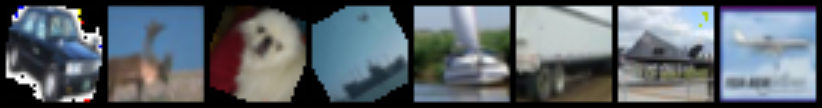

In [8]:
grid = plot_grid_from_tensors(imgs[:8])
print(*[data.classes[i] for i in labels.numpy()[:8]], sep='       ')
grid.resize(np.array(grid.size)*3, PIL.Image.BILINEAR)

In [9]:
imgs.shape

torch.Size([1000, 3, 32, 32])

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu';print (device)

cuda


In [11]:
class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding=0, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), padding=0, stride=1)
        self.pooling = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.dropout = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(1152, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
    def forward(self, x):
        x = F.relu(self.conv1(self.dropout(x)))
        x = self.pooling(x)
        x = F.relu(self.conv2(self.dropout(x)))
        x = self.pooling(x)
        x = F.relu(self.conv3(self.dropout(x)))
        x = F.relu(self.conv4(self.dropout(x)))
        x = self.pooling(x)
        batch, dim1, dim2 = x.shape[-3:]
        x = x.view(-1, batch*dim1*dim2)
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        x = F.relu(self.fc3(self.dropout(x)))
        x = self.fc4(x)
        return x

In [12]:
model = CifarNet()
min_loss = np.inf

out = model(imgs[:8])
out.shape

torch.Size([8, 10])

In [13]:
torch.backends.cudnn.enabled

True

## Let's see the problem of vanishing grads 

In [14]:
# making an ordered dict with param name as a key and size + a list to hold gradients
from collections import OrderedDict
from functools import reduce
# store grads
vanish_grads = OrderedDict()
# store size of layer in number of parameters
layer_param_size = OrderedDict()
for name, param in model.named_parameters():
    layer_param_size[name] = reduce(torch.mul, torch.as_tensor(param.shape)).item()
    vanish_grads[name] = []

vanish_grads,layer_param_size

(OrderedDict([('conv1.weight', []),
              ('conv1.bias', []),
              ('conv2.weight', []),
              ('conv2.bias', []),
              ('conv3.weight', []),
              ('conv3.bias', []),
              ('conv4.weight', []),
              ('conv4.bias', []),
              ('fc1.weight', []),
              ('fc1.bias', []),
              ('fc2.weight', []),
              ('fc2.bias', []),
              ('fc3.weight', []),
              ('fc3.bias', []),
              ('fc4.weight', []),
              ('fc4.bias', [])]),
 OrderedDict([('conv1.weight', 1728),
              ('conv1.bias', 64),
              ('conv2.weight', 36864),
              ('conv2.bias', 64),
              ('conv3.weight', 36864),
              ('conv3.bias', 64),
              ('conv4.weight', 8192),
              ('conv4.bias', 128),
              ('fc1.weight', 1179648),
              ('fc1.bias', 1024),
              ('fc2.weight', 524288),
              ('fc2.bias', 512),
              ('fc3

In [33]:
N_EPOCH = 100

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

model.to(device)

for epoch in tqdm(range(N_EPOCH)):
    
    running_loss = 0 
    model.train()
    # train one epoch
    for imgs, labels in train_data_loader:     
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(imgs)
        loss = criterion(scores, labels)
        loss.backward()
        
        # store the grads
        for name, parameter in model.named_parameters():
            # adding a pair of values - (epoch, sum of all grads in parameter by number of parameters and number of samples in batch)
            vanish_grads[name].append(parameter.grad.norm().item()/layer_param_size[name]/len(imgs))
        
        optimizer.step()
        running_loss += loss.item()
        
    running_loss = running_loss/len(train_data_loader.sampler)
    
    # get the loss on the validation set
    model.eval()
    eval_loss = 0 
    with torch.no_grad():
        for imgs, labels in valid_data_loader:     
            imgs, labels = imgs.to(device), labels.to(device)
            scores = model(imgs)
            loss = criterion(scores, labels)
            eval_loss += loss.item()
        
    eval_loss = eval_loss/len(valid_data_loader.sampler)
    
    # make a print out
    print(f"Epoch {epoch:2}\t Train loss {running_loss:.4f}\tValid loss {eval_loss:.4f}")
    if eval_loss < min_loss:
        print("Nice :) Loss decreasing... Saving model")
        torch.save(model.state_dict(), 'cifar.pt')
        min_loss = eval_loss

Epoch  0	 Train loss 0.9420	Valid loss 0.9911
Epoch  1	 Train loss 0.9304	Valid loss 1.0062
Epoch  2	 Train loss 0.9268	Valid loss 1.0237
Epoch  3	 Train loss 0.9244	Valid loss 0.9784
Epoch  4	 Train loss 0.9140	Valid loss 1.0336
Epoch  5	 Train loss 0.9140	Valid loss 1.0080
Epoch  6	 Train loss 0.9248	Valid loss 1.0053
Epoch  7	 Train loss 0.9117	Valid loss 0.9870
Epoch  8	 Train loss 0.9053	Valid loss 0.9922
Epoch  9	 Train loss 0.8836	Valid loss 0.9687
Epoch 10	 Train loss 0.9024	Valid loss 0.9728
Epoch 11	 Train loss 0.8904	Valid loss 0.9608
Epoch 12	 Train loss 0.8897	Valid loss 1.0282
Epoch 13	 Train loss 0.8943	Valid loss 0.9534
Epoch 14	 Train loss 0.8743	Valid loss 0.9516
Epoch 15	 Train loss 0.8920	Valid loss 1.0041
Epoch 16	 Train loss 0.8834	Valid loss 1.0140
Epoch 17	 Train loss 0.8774	Valid loss 0.9973
Epoch 18	 Train loss 0.8762	Valid loss 1.0197
Epoch 19	 Train loss 0.8850	Valid loss 0.9979
Epoch 20	 Train loss 0.8763	Valid loss 0.9897
Epoch 21	 Train loss 0.8712	Valid 

In [25]:
import pandas as pd

In [34]:
pd_vg = pd.DataFrame(vanish_grads)

In [27]:
pd_vg.head()

conv1.weight  conv1.bias  conv2.weight  conv2.bias  conv3.weight  \
0  3.625903e-07    0.000003  9.602101e-08    0.000006  1.059414e-07   
1  4.934325e-07    0.000004  1.191308e-07    0.000006  1.281803e-07   
2  8.161343e-07    0.000005  1.712922e-07    0.000008  1.653088e-07   
3  2.291586e-06    0.000012  3.752572e-07    0.000015  3.678826e-07   
4  3.107337e-06    0.000029  5.042152e-07    0.000041  5.357800e-07   

   conv3.bias  conv4.weight  conv4.bias    fc1.weight  fc1.bias    fc2.weight  \
0    0.000010  1.688081e-07    0.000012  6.894686e-09  0.000002  1.516692e-08   
1    0.000013  1.850705e-07    0.000015  7.878558e-09  0.000003  2.126550e-08   
2    0.000012  2.993184e-07    0.000016  9.554650e-09  0.000003  2.910864e-08   
3    0.000025  5.183151e-07    0.000018  1.150415e-08  0.000003  3.404816e-08   
4    0.000060  6.965563e-07    0.000051  1.449325e-08  0.000004  4.656280e-08   

   fc2.bias    fc3.weight  fc3.bias  fc4.weight  fc4.bias  
0  0.000011  4.733444e-08  0.000042    0.000003  0.002433  
1  0.000014  7.978967e-08  0.000055    0.000005  0.003572  
2  0.000011  1.214140e-07  0.000041    0.000006  0.002243  
3  0.000012  1.566984e-07  0.000049    0.000008  0.002961  
4  0.000015  2.284485e-07  0.000063    0.000013  0.004023

In [28]:
import plotly.express as px

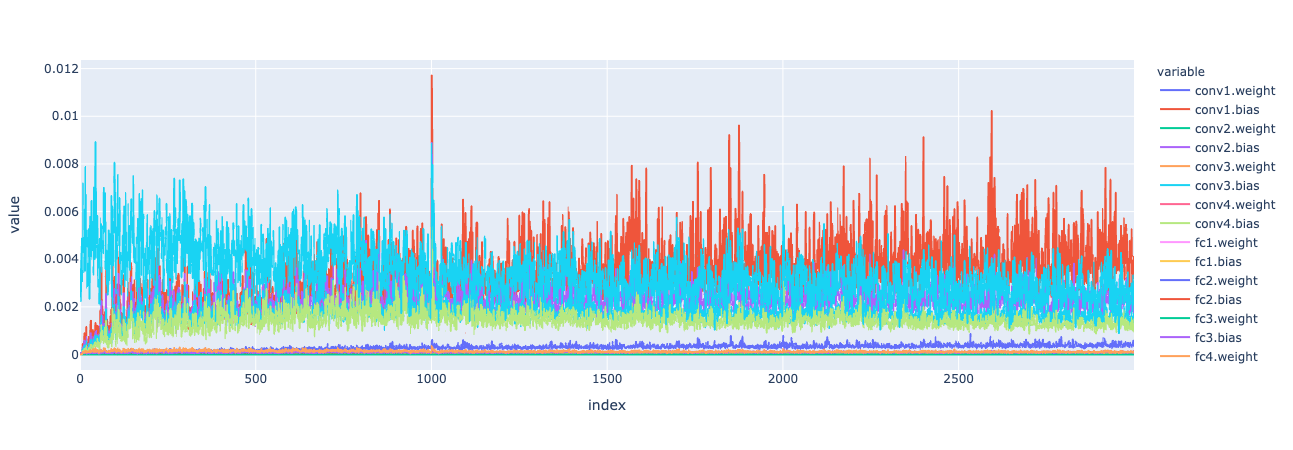

In [35]:
fig = px.line(pd_vg)
fig.show()

In [36]:
model_params = torch.load('cifar.pt')
model.load_state_dict(model_params)

<All keys matched successfully>

## Calc the metrics

In [133]:
batch_size = 1000
test_data = datasets.CIFAR10(root='/home/testuser/backup_folder/data/cifar10', download=True, transform=valid_transform, train=False)
# train_data_loader = DataLoader(test_data, batch_size=len(test_data))
test_data_loader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified


In [134]:
model.to(device)
model.eval()
positives = 0
positives_by_class = [0. for item in test_data.classes]
class_total = [0 for item in test_data.classes]
with torch.no_grad():
    for imgs, labels in test_data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        scores = model(imgs)
        _, pred_labels = torch.max(scores, dim=1)
        positives += (pred_labels == labels).to('cpu').numpy().sum()
        
        for cifar_class_id in range(len(test_data.classes)):
            pred_class_idx = set((pred_labels == cifar_class_id).nonzero().flatten().cpu().numpy())
            target_class_idx = set((labels == cifar_class_id).nonzero().flatten().cpu().numpy())
            positives_by_class[cifar_class_id] += len(target_class_idx.intersection(pred_class_idx))
            class_total[cifar_class_id] += len(target_class_idx)
        
for i, (class_positives, cifar_class) in enumerate(zip(positives_by_class, test_data.classes)):
    print(f' {cifar_class:15} \t {class_positives/class_total[i]:.0%} = {class_positives:.0f}/{class_total[i]}')
print(f'\nOverall accuracy is {positives/len(test_data):.1%} = {sum(positives_by_class):.0f}/{len(test_data)}')

 airplane        	 76% = 762/1000
 automobile      	 86% = 865/1000
 bird            	 56% = 558/1000
 cat             	 43% = 430/1000
 deer            	 72% = 715/1000
 dog             	 56% = 556/1000
 frog            	 87% = 871/1000
 horse           	 76% = 765/1000
 ship            	 87% = 870/1000
 truck           	 76% = 765/1000

Overall accuracy is 71.6% = 7157/10000


## Visualize the 1st conv layer 

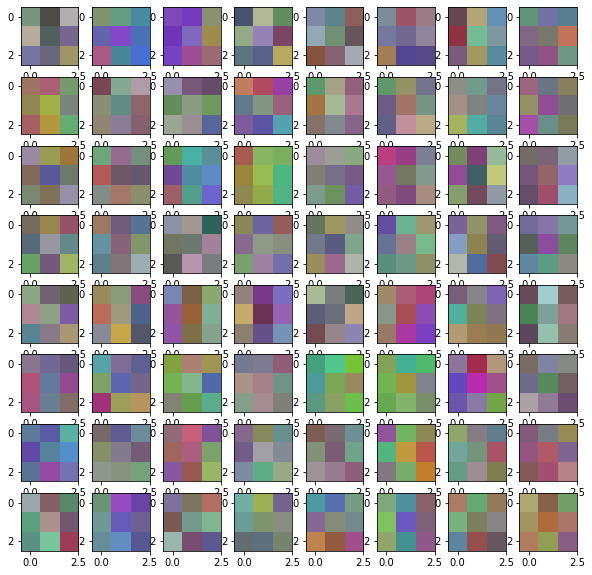

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
for j in range(grid_dim//8):
    for k in range(grid_dim//8):
        ax = fig.add_subplot(8,8,j*8+k+1)
        Min, Max = model.conv1.weight.data[j*8+k,:,:,:].cpu().numpy().min(), model.conv1.weight.data[j*8+k,:,:,:].cpu().numpy().max()
        ax.imshow((model.conv1.weight.data[j*8+k,:,:,:].cpu().numpy()-Min)/(Max-Min))
        #ax.imshow((model.conv1.weight.data[j*8+k,:,:,:].cpu().numpy()+1/2))

In [136]:
from torchvision.models import resnet50

In [138]:
resnet = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/testuser/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [141]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [140]:
!cat  /usr/local/lib/python3.6/dist-packages/torchvision/models/resnet.py

import torch
import torch.nn as nn
from .utils import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/m